In [1]:
import cv2
import numpy as np
import scipy as sp
from PIL import Image
from scipy.ndimage.measurements import label
from skimage.measure import regionprops
from skimage import data
from skimage import filters
from skimage import exposure
import matplotlib.pyplot as plt
from matplotlib import patches
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config =  ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config=config)

In [2]:
def normalization(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

def generate_bbox(feature_map, threshold):
    labeled, nr_objects = label(cam > threshold)
    props = regionprops(labeled)

    init = props[0].bbox_area
    bbox = list(props[0].bbox)
    for b in props:
        if init < b.bbox_area:
            bbox = list(b.bbox)
    return bbox

In [3]:
model = load_model('model/vgg16_voc2007')
# model = VGG16(weights='imagenet', include_top=False)

In [4]:
img = Image.open('000258.jpg').resize((224, 224))
# img = Image.open('002153.jpg').resize((224, 224))
img_arr = np.asarray(img)[:, :, :3] / 255.
x = np.expand_dims(img_arr, 0)

In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    print(i, layer.name, layer.output.shape)

# Phase 1

In [5]:
# Feature map을 추출할 layer 결정
block = [1, 4, 8, 12, 16]
outputs = [model.layers[i].output for i in block]
feature_map_extraction_model = Model([model.inputs], outputs)

In [6]:
# Layer별 feature map 추출
feature_maps = {}
feature_maps_list = feature_map_extraction_model.predict(x)

for i, fmap in enumerate(feature_maps_list):
    feature_maps[f'conv{i}'] = tf.convert_to_tensor(np.squeeze(fmap))

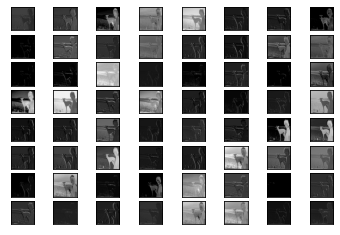

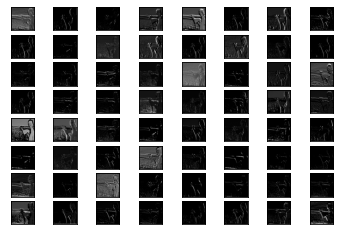

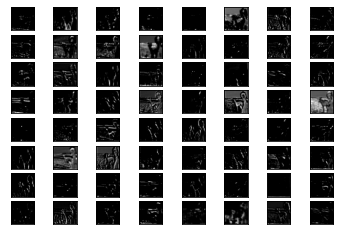

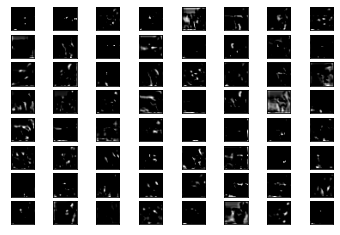

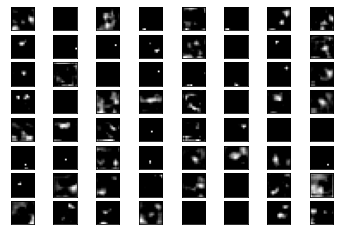

In [7]:
# Featuremap visualization
square = 8
for fmap in feature_maps_list:
    i = 1
    for _ in range(square):
        for _ in range(square):
            ax = plt.subplot(square, square, i)
            ax.set_xticks([])
            ax.set_yticks([])

            plt.imshow(fmap[0, :, :, i-1], cmap='gray')
            i += 1
    plt.show()

# Phase 2
- Feature map filtering

In [8]:
# conv layer별 피쳐맵과 confidence score(softmax 값)의 gradient 계산
block = [1, 4, 8, 12, 16, 18]
outputs = [model.layers[i].output for i in block]

grad_model = Model([model.inputs], outputs)

with tf.GradientTape(persistent=True) as tape:
    *conv_outputs, pred = grad_model(x)
    class_channel = pred[:, 11]

grads = {}
for i, conv in enumerate(conv_outputs):
    grads[f'conv{i}'] = tape.gradient(class_channel, conv)[0]

In [9]:
print(f"max : {np.max(tf.reduce_mean(grads['conv0'], axis=(0,1)))}")
print(f"argmax : {np.argmax(tf.reduce_mean(grads['conv0'], axis=(0,1)))}")
print(f"min : {np.min(tf.reduce_mean(grads['conv0'], axis=(0,1)))}")
print(f"argmin : {np.argmin(tf.reduce_mean(grads['conv0'], axis=(0,1)))}")

max : 9.580160167388385e-07
argmax : 34
min : -7.44431133625767e-07
argmin : 26


In [10]:
# 피쳐맵의 평균 gradient 계산
avg_grads = {}
for k, v in grads.items():
    avg_grads[k] = tf.reduce_mean(v, axis=(0,1))

In [11]:
# 피쳐맵의 평균 gradient가 0이 넘는 피쳐맵만 필터링
filtered_feature_maps = {}
for k, v in avg_grads.items():
    transpose = tf.transpose(feature_maps[k], perm=[2,0,1])[v>0] # 필터링 용이를 위해 transpose
    filtered_feature_maps[k] = tf.transpose(transpose, perm=[1,2,0]) # transpose 다시 되돌리기

In [12]:
# 필터링 된 피쳐맵 수 비교
sum1 = sum2 = 0
for k1, k2 in zip(avg_grads.values(), filtered_feature_maps.values()):
    print(f'{len(k1)} -> {k2.shape[-1]}, {len(k1)-k2.shape[-1]}개 감소 (감소율: {(k2.shape[-1]-len(k1))/len(k1)*100}%)')
    sum1 += len(k1)
    sum2 += k2.shape[-1]

print('\nTotal')
print(f'{sum1} -> {sum2}, {sum1-sum2}개 감소 (감소율: {(sum2-sum1)/sum1*100}%)')

64 -> 28, 36개 감소 (감소율: -56.25%)
128 -> 71, 57개 감소 (감소율: -44.53125%)
256 -> 125, 131개 감소 (감소율: -51.171875%)
512 -> 270, 242개 감소 (감소율: -47.265625%)
512 -> 261, 251개 감소 (감소율: -49.0234375%)

Total
1472 -> 755, 717개 감소 (감소율: -48.70923913043478%)


# Phase 2
- Post-processing

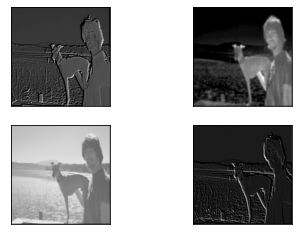

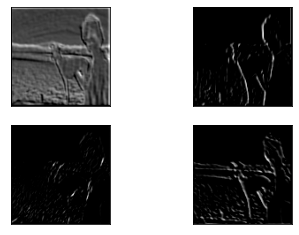

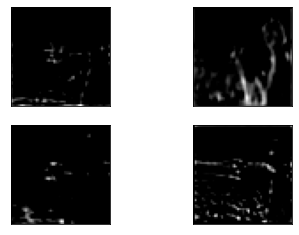

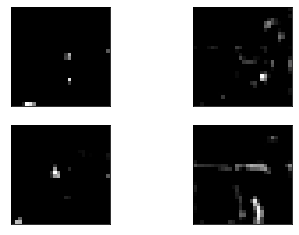

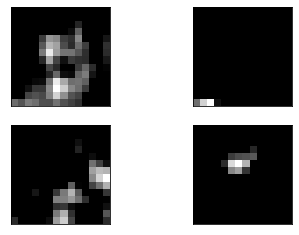

In [13]:
# 필터링된 피쳐맵 확인
# plt.imshow(filtered_feature_maps['conv0'][:,:,0], cmap='gray')

# Featuremap visualization
square = 2
for k in filtered_feature_maps.keys():
    i = 1
    for _ in range(square):
        for _ in range(square):
            ax = plt.subplot(square, square, i)
            ax.set_xticks([])
            ax.set_yticks([])

            plt.imshow(filtered_feature_maps[k][:, :, i-1], cmap='gray')
            i += 1
    plt.show()

In [14]:
# Bilinear interpolation
postprocessed_feature_maps = {}
for k in filtered_feature_maps.keys():
    postprocessed_feature_maps[k] = cv2.resize(filtered_feature_maps[k].numpy(), (224,224), interpolation=cv2.INTER_LINEAR)
    for i in range(postprocessed_feature_maps[k].shape[-1]):
        if np.max(postprocessed_feature_maps[k][:,:,i]) == 0.0:
            continue
        postprocessed_feature_maps[k][:,:,i] = (postprocessed_feature_maps[k][:,:,i] - np.min(postprocessed_feature_maps[k][:,:,i]))/(np.max(postprocessed_feature_maps[k][:,:,i])-np.min(postprocessed_feature_maps[k][:,:,i]))

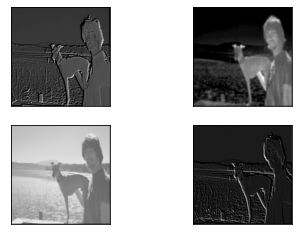

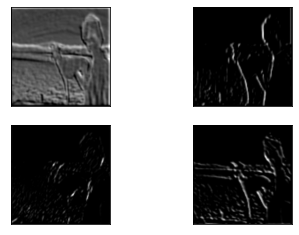

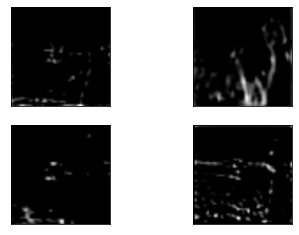

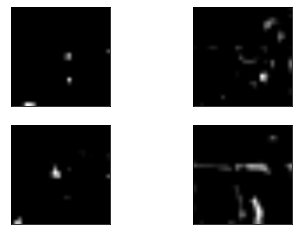

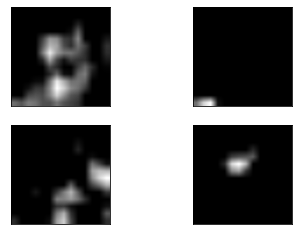

In [15]:
square = 2
for k in postprocessed_feature_maps.keys():
    i = 1
    for _ in range(square):
        for _ in range(square):
            ax = plt.subplot(square, square, i)
            ax.set_xticks([])
            ax.set_yticks([])

            plt.imshow(postprocessed_feature_maps[k][:, :, i-1], cmap='gray')
            i += 1
    plt.show()

In [47]:
def ostu_binary(x):
    thr = filters.threshold_otsu(x)
    binary = x > thr
    return np.multiply(binary, 255)

def IoU(boxA, boxB):
    xA = max(boxA[1], boxB[1])
    yA = max(boxA[0], boxB[0])
    xB = min(boxA[3], boxB[3])
    yB = min(boxA[2], boxB[2])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [34]:
# Calculate sum of all feature maps
sum_featurempas = {}
for k, v in filtered_feature_maps.items():
    sum_featurempas[k] = tf.reduce_sum(v, axis=(0,1))

# Sum of all feature maps != 0 filtering
not_zero_feature_maps = {}
for k, v in sum_featurempas.items():
    transpose = tf.transpose(filtered_feature_maps[k], perm=[2,0,1])[v!=0] # 필터링 용이를 위해 transpose
    not_zero_feature_maps[k] = tf.transpose(transpose, perm=[1,2,0]) # transpose 다시 되돌리기

In [37]:
# Bilinear interpolation
postprocessed_feature_maps = {}
for k in not_zero_feature_maps.keys():
    postprocessed_feature_maps[k] = cv2.resize(not_zero_feature_maps[k].numpy(), (224,224), interpolation=cv2.INTER_LINEAR)
    for i in range(postprocessed_feature_maps[k].shape[-1]):
        if np.max(postprocessed_feature_maps[k][:,:,i]) == 0.0:
            continue
        postprocessed_feature_maps[k][:,:,i] = (postprocessed_feature_maps[k][:,:,i] - np.min(postprocessed_feature_maps[k][:,:,i]))/(np.max(postprocessed_feature_maps[k][:,:,i])-np.min(postprocessed_feature_maps[k][:,:,i]))

In [105]:
layers = ['conv3', 'conv4']

layer_bbox = {}

# conv3, conv4 레이어의 feature map들 bbox 좌표 계산
for layer in layers:
    layer_bbox[layer] = []
    for index in range(postprocessed_feature_maps[layer].shape[2]):
        binary = ostu_binary(postprocessed_feature_maps[layer][:,:,index])
        labeled, nr_objects = label(binary > 0)
        props = regionprops(labeled)

        init = props[0].bbox_area
        bbox = tuple(props[0].bbox)
        for b in props:
            if init < b.bbox_area:
                init = b.bbox_area
                bbox = tuple(b.bbox)

        layer_bbox[layer].append(bbox)

# IoU가 0.5 이상인 feature map끼리 grouping
group_bbox = {}
for k in layer_bbox.keys():
    temp = layer_bbox[k].copy()
    group_bbox[k] = []
    for i in range(len(temp)):
        if temp[i] == 0:
            continue
        temp_group = [i]
        for j in range(i+1, len(temp)):
            if temp[j] == 0:
                continue
            if IoU(temp[i], temp[j]) >= 0.5:
                temp_group.append(j)
                temp[j] = 0
        temp[i] = 0
        group_bbox[k].append(temp_group)

compressed_feature_maps = {}

for layer in layers:
    for b in group_bbox[layer]:
        compressed_feature_map = np.zeros_like(postprocessed_feature_maps[layer][:,:,0].shape)
        for i, feature_map_index in enumerate(b):
            if i == 0:
                compressed_feature_map = postprocessed_feature_maps[layer][:,:, feature_map_index]
            else:
                compressed_feature_map += postprocessed_feature_maps[layer][:,:, feature_map_index]

        if layer in compressed_feature_maps:
            compressed_feature_maps[layer] = np.concatenate((compressed_feature_maps[layer], np.expand_dims(normalization(compressed_feature_map), axis=2)), axis=2)
        else:
            compressed_feature_maps[layer] = np.expand_dims(normalization(compressed_feature_map), axis=2)


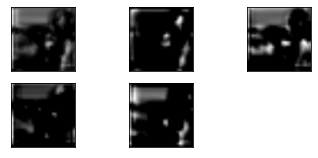

In [147]:
[4, 32, 71, 99, 191]

ax = plt.subplot(3, 3, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(postprocessed_feature_maps['conv3'][:,:,4], cmap='gray')
ax = plt.subplot(3, 3, 2)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(postprocessed_feature_maps['conv3'][:,:,32], cmap='gray')
ax = plt.subplot(3, 3, 3)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(postprocessed_feature_maps['conv3'][:,:,71], cmap='gray')
ax = plt.subplot(3, 3, 4)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(postprocessed_feature_maps['conv3'][:,:,99], cmap='gray')
ax = plt.subplot(3, 3, 5)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(postprocessed_feature_maps['conv3'][:,:,191], cmap='gray')
plt.show()


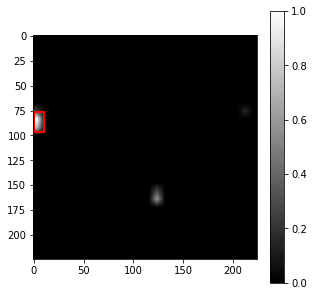

In [38]:
index = 77
layer = 'conv3'

binary = ostu_binary(postprocessed_feature_maps[layer][:,:,index])

labeled, nr_objects = label(binary > 0)
props = regionprops(labeled)

plt.figure(figsize=(5,5))
plt.imshow(postprocessed_feature_maps[layer][:,:,index], cmap='gray')
# plt.imshow(result, cmap='jet', alpha=0.5)
plt.colorbar()
ax = plt.gca()

init = props[0].bbox_area
bbox = tuple(props[0].bbox)
for b in props:
    if init < b.bbox_area:
        init = b.bbox_area
        bbox = tuple(b.bbox)
rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.show()

In [17]:
layer = 'conv3'
for l in postprocessed_feature_maps[layer]:
    thr = filters.threshold_otsu(postprocessed_feature_maps[layer][:,:,index])
    binary = postprocessed_feature_maps[layer][:,:,index] > thr
    binary = np.multiply(binary, 255)

    labeled, nr_objects = label(binary > 0)
    props = regionprops(labeled)

# Phase 3
{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

In [ ]:
layer_visualization_map = {}

for k in postprocessed_feature_maps.keys():
    masks = np.expand_dims(tf.transpose(postprocessed_feature_maps[k], perm=[2,0,1]), axis=-1)
    masked = x*masks
    preds = model.predict(masked)
    layer_visualization_map[k] = preds.T.dot(masks.reshape(masks.shape[0],-1)).reshape(-1, 224,224)
    plt.imshow(masked[0])
    plt.show()

In [ ]:
# Block별 layer visualization map 결과
for k in layer_visualization_map.keys():
    plt.imshow(img)
    plt.imshow(layer_visualization_map[k][6], cmap='jet', alpha=0.5)
    plt.colorbar()
    plt.show()

In [ ]:
index = 11
result = normalization(layer_visualization_map['conv0'][index]).copy()

for k in layer_visualization_map.keys():
    if k == 'conv0':
        continue
    result += normalization(layer_visualization_map[k][index])
    thr = filters.threshold_otsu(normalization(layer_visualization_map[k][index]))
    binary = normalization(layer_visualization_map[k][index]) > thr
    binary = np.multiply(binary, 255)
    result = result * binary

# Result

In [ ]:
plt.imshow(img)
plt.imshow(result, cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

In [ ]:
'''
bbox (list): upper left and lower right coordinates of object bounding box
saliency_map (array): explanation map, ignore the channel
'''
def energy_point_game(bbox, saliency_map): # GT 부분의 활성화 값 / 전체 활성화 값
  
  x1, y1, x2, y2 = bbox
  w, h = saliency_map.shape
  
  empty = np.zeros((w, h))
  empty[y1:y2, x1:x2] = 1
  mask_bbox = saliency_map * empty  
  
  energy_bbox =  mask_bbox.sum()
  print(energy_bbox)
  energy_whole = saliency_map.sum()
  print(energy_whole)
  proportion = energy_bbox / energy_whole
  
  return proportion

In [ ]:
import xml.etree.ElementTree as ET
import os

label_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/Annotations'
tree = ET.parse(f'{label_path}/000258.xml')
root = tree.getroot()

In [ ]:
for obj in root.iter('object'):
    if obj.find('name').text == 'dog':
        xmin = int(obj.find('bndbox').findtext('xmin'))
        ymin = int(obj.find('bndbox').findtext('ymin'))
        xmax = int(obj.find('bndbox').findtext('xmax'))
        ymax = int(obj.find('bndbox').findtext('ymax'))

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.imshow(result, cmap='jet', alpha=0.5)
plt.colorbar()
ax = plt.gca()
rect = patches.Rectangle((b['xmin'], b['ymin']), b['w'], b['h'], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

In [ ]:
a = Image.open('000258.jpg')

In [ ]:
def get_label(xml):
    p_size = xml.find('size')
    p_box = xml.find('object').find('bndbox')
    size = {'width':int(p_size.find('width').text),'height': int(p_size.find('height').text)}
    box = {'xmin':int(p_box.find('xmin').text), 'ymin' : int(p_box.find('ymin').text),'xmax': int(p_box.find('xmax').text),'ymax': int(p_box.find('ymax').text)}
    xmin, ymin, xmax, ymax = box['xmin'] / size['width'] * 224, box['ymin'] / size['height'] * 224, box['xmax'] / size['width'] * 224,box['ymax'] / size['height'] * 224
    w, h = xmax - xmin, ymax - ymin
    return {'xmin':xmin, 'ymin':ymin, 'xmax':xmax,'ymax':ymax,'w':w, 'h':h}

In [ ]:
b = get_label(tree)